# 4.2 Blob detection and description

Now, we are going to deal with another type of keypoints. Corners and edges were already covered, so it is time for **blobs**!  

Informally, a blob is a region of an image in which some properties are constant or approximately constant. All the points in a blob can be considered in some sense to be similar to each other. Blobs provide complementary information about regions, which is not obtained from edges or corners.

Scale-invariant feature transform (**SIFT**) is a blob detection and description algorithm, its implementation is more complex than Harris but easier to use in openCV. In this notebook we will understand the main steps involved in SIFT algorithm and how can be implemented.

## Problem context - Image stitching

In notebook 4.1, Harris corner detector + NCC was proposed to find correspondences between images for an image stitching system. But this is just not enough, a lot of the blame lies with description through NCC. This is because it is not invariant to rotation, there is no possible matching between rotated images. Also, it does not differentiate points in repetitive elements (e.g. windows in a skyscraper):$\\[10pt]$

<img src="./images/ncc_problem.jpg" width="300" align="left"/><img src="./images/skyscraper.jpg" width="300" align="rigth"/>

## SIFT

As SIFT is patented, it is no longer included in openCV. We are going to use **[pysift](https://github.com/rmislam/PythonSIFT)**, a third party code that implements it like an openCV method (only for educational purposes), returning [cv2.KeyPoint](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html) objects.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from ipywidgets import interact, fixed, widgets
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
images_path = './images/'

import sys
sys.path.append("..")
from utils.third_party import pysift #https://github.com/rmislam/PythonSIFT

First to understand is, **how SIFT detector works**?

### Step 1: Contruction of octaves

SIFT progressivelly blurs (applying gaussian filter) the input image, applying each time a greater standard deviation. Once you have $s$ images (i.e. a sequence of 6 blurred images), the **octave** is completed. Then, image resolution reduces to a half and blurring continues.  
We repeat this process until the pictures are too small to proceed:$\\[5pt]$

<img src="./images/sift_octave.png" width="800"/>$\\[5pt]$

The blue arrow shows the beginning of a new octave, the green arrow shows a gaussian blurring. As you can see, in the example we have octaves of 6 images ($s = 6$) and 4 octaves (resolution is downsampled 4 times).

### Step 2: Difference of Gaussians (DoG)

For each pair of horizontally adjacent pictures in the table above, we compute the differences of the individual pixels. In this way, we have of $s-1$ DoG images for each octave:$\\[5pt]$

<img src="./images/octave_dog.png" width="800"/>$\\[5pt]$

Difference of Gaussian is a different and more efficient way to implement LoG (laplacian of Gaussian), which is covered in notebook 3.2.

### Step 3: Extreme points

For detecting blobs in SIFT, extreme points are searched. Each pixel is compared with its 26 neighbors (8 in the same image, 9 in the left image and 9 in the right image). An extreme point can be a maximum or a minimum, if the pixel is greater or lower than all its 26 neighbors it is considered as a keypoint.

*Note that this is only possible for DoG images that are not the first or the last image in that scale.*$\\[5pt]$

<img src="./images/sift_keypoints.png" width="500"/>$\\[5pt]$

We can see local maximum points in yellow and local minimum points in red. 

<img src="./images/neighbors.png" width="500"/>$\\[5pt]$

### Step 4: Compute descriptors

SIFT keypoints descriptor are histogram of orientations around the extreme point weighted by:

- Magnitude of the gradient
- Gaussian centered at the extreme point

<img src="./images/sift_descriptor.png" width="800"/>$\\[5pt]$

This have been a short resume where a lot of small details have been skipped. If you want a fully detailed explanation of the algorithm, [press here](http://weitz.de/sift/index.html?size=large).


Coming back to code, pysift defines main function `pysift.computeKeypointsAndDescriptors` which only input is a grey image. It returns a list of cv2.KeyPoint objects and one array with shape $\left(n\_keypoints,4x4x8\right)$ being the 128D descriptor of each keypoint.

**What to do?** Compute `sift_2.jpeg` keypoints using SIFT and display the image with keypoints.

*Note that for drawing complex keypoints (as obtained using SIFT), we can use `flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS` in drawing method*

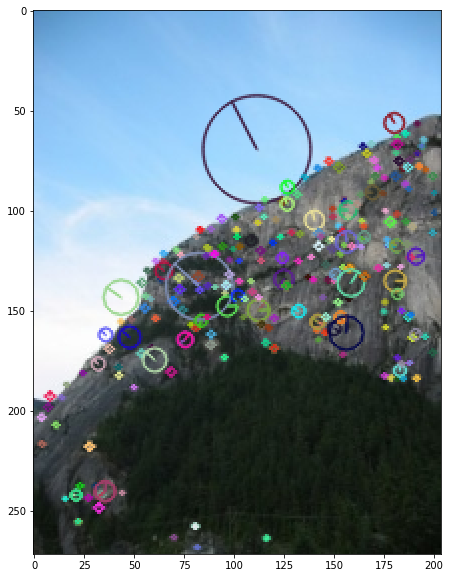

In [2]:
# Read image
image = cv2.imread(images_path + 'sift_2.jpeg')
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

# Obtain gray image
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

# Compute blobs and descriptors using SIFT
kps, descriptors = pysift.computeKeypointsAndDescriptors(gray)

# Draw blobs
image_corners = np.copy(image)
cv2.drawKeypoints(image,kps,image_corners,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) # Use rich keypoints flag

# Show image and blobs
plt.imshow(image_corners)

Now, we are going to match two images of a mointain: `sift_1.jpeg` and `sift_2.jpeg`, which have overlapping fields.$\\[5pt]$

<img src="./images/mountain_1.jpg" width="300" align="left"/><img src="./images/mountain_2.jpg" width="300" align="rigth"/>$\\[5pt]$

*For this exercise, images have been downsampled in order to compute keypoints faster*

**What to do?** Follow next steps for developing a keypoint matching system using SIFT descriptors.

Similar to harris, we are going to do this step by step:

- **First compute keyoints and descriptors for each image.**

In [3]:
#Read both images
image_1 = cv2.imread(images_path + 'sift_1.jpeg')
image_1 = cv2.cvtColor(image_1,cv2.COLOR_BGR2RGB)
image_2 = cv2.imread(images_path + 'sift_2.jpeg')
image_2 = cv2.cvtColor(image_2,cv2.COLOR_BGR2RGB)

# Get gray images
gray_1 = cv2.cvtColor(image_1,cv2.COLOR_RGB2GRAY)
gray_2 = cv2.cvtColor(image_2,cv2.COLOR_RGB2GRAY)

# Compute blobs and descriptors
kps_1, des_1 = pysift.computeKeypointsAndDescriptors(gray_1)
kps_2, des_2 = pysift.computeKeypointsAndDescriptors(gray_2)

- **Then, find matches between keypoints**

*When you match keypoints, you actually match their descriptors.*

openCV define many methods to match descriptors. In this exercise we are going to use knnMatch ($K$-Nearest Neighbors), it will return a list of (the best) $K$ matches instead of a single DMatch. If we use $K=2$ we will get 2 matches for each keypoint, the 2 nearests matches. The distance between two descriptors is given at `DMatch.distance`. If distance is very low, then keypoints are similar.

Use `cv2.BFMatcher().knnMatch()` [(documentation)](https://docs.opencv.org/3.4/db/d39/classcv_1_1DescriptorMatcher.html#a378f35c9b1a5dfa4022839a45cdf0e89) to obtain the list of matches, then print the first match and their distances.

In [4]:
# Call knnMatch
matches = cv2.BFMatcher().knnMatch(des_1,des_2, k=2)

# Print first match distances
print(matches[0][0].distance, matches[0][1].distance)

315.7704772949219 363.8131408691406


- **Filter non-robust matches**

Here is why KNN have been chosen. We will only accept matches that have not 2 close solutions (similar distance), because it means that SIFT is not sure at all about the solution.  

Iterate the matches list filtering those matches that does not fulfil the condition.

In [5]:
good = []
# For each match
for m,n in matches:
    # If first two distances are not close
    if m.distance < 0.75*n.distance:
        # It is a good match! Add it to the list
        good.append(m)

- Finally, **display the images drawing before computed (and filtered) matches**

*Remember to use `flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`*

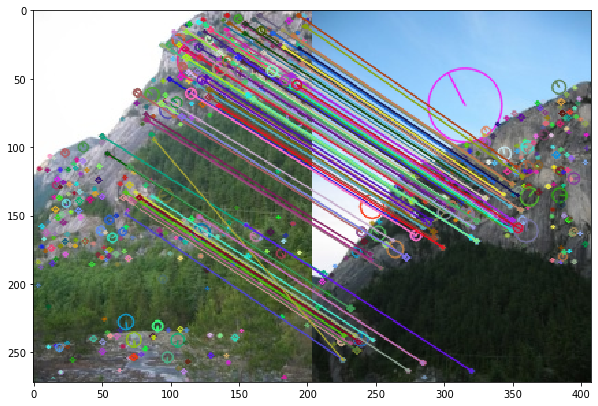

In [6]:
# Draw matches
image_matches = np.copy(image_1)
image_matches = cv2.drawMatches(image_1,kps_1,image_2,kps_2,good,image_matches, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# And finally show them
plt.imshow(image_matches)

**Answer following questions**

- Looking at the results, could a system stitch both images?  
  
- How do you think it could be done?

## Conclusion

SIFT is patented and you are suposed to pay it for its use. There are some official alternatives in openCV like [ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html).   
Anyway, SIFT is one of the **best algorithm for feature detection**, it is mandatory to learn how it was acomplished and how it works.


### Extra

If you want to learn more about SIFT, you can look through the [original paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwi7y_G-xrDoAhUGHcAKHWn1DIsQFjAAegQIBRAB&url=https%3A%2F%2Fwww.cs.ubc.ca%2F~lowe%2Fpapers%2Fijcv04.pdf&usg=AOvVaw0cBGKtFZfTh8Vf_Y4kP3LS) by David Lowe. It was proposed in 1999 and published in 2004.